# Absolute Quantitation 

Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

A common goal in chromatography is to quantify with physically meaningful units
the concentration of an analyte in a solution. While Chromatography will not
give that to you directly off the instrument, you can prepare a "standard
curve"--a set of solutions where you *know* the concentration of the analyte of
interest.  With a properly configured machine, one can make a direct linear
relation between the integrated area of a peak and the concentration of the analyte. 
In this tutorial, we will use `hplc-py` to quantify a standard curve of a lactose 
solution and then use the `.map_peaks` method of the `Chromatogram` object to 
test our calibration curve. 

## Generating a Calibration Curve
Here, we will use `hplc-py` to quantify aqueous solutions of lactose in different 
concentrations. These files have been preprocessed to have the known lactose 
concentration in the file name. 

In [1]:
import glob 

# Get the list of files
files = glob.glob('data/calibration/lactose*.csv')
print(files[0])

data/calibration/lactose_mM_6.csv


We can load this file into memory as a chromatogram using the `load_chromatogram`
function from the `io` module and instantiate a `Chromatogram` object.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

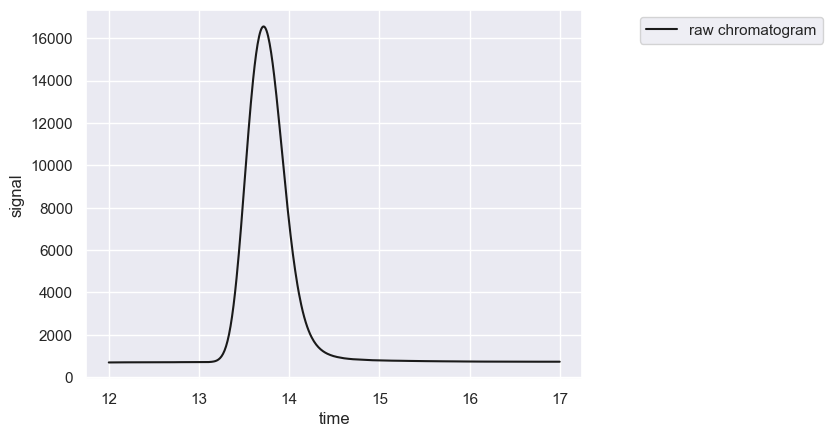

In [2]:
from hplc.io import load_chromatogram
from hplc.quant import Chromatogram 

# Load and display the first file. 
df = load_chromatogram(files[0], cols=['time', 'signal'])
chrom = Chromatogram(df)
chrom.show()

As a reminder, we can quickly quantify this single peak by calling the `.fit_peaks`
method. 

,retention_time,scale,skew,amplitude,area,peak_id
0,13.56,0.281241,1.654727,8004.452381,960534.285711,1


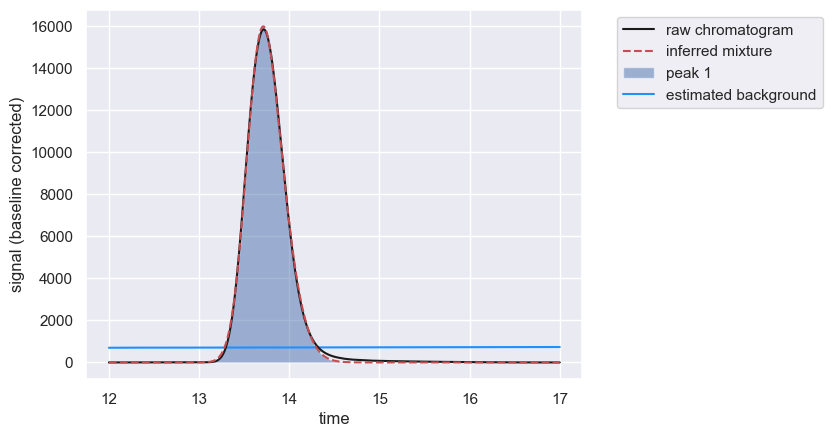

In [4]:
# Quantify the peak
peaks = chrom.fit_peaks(verbose=False)
chrom.show()
peaks.head()

While it's useful to know the various parameters returned by the fitting, we are
fundamen We are interested in the integrated area of the peak (integrated over
the entire duration of the chromatogram).  Using a for loop and getting the concentration 
of lactose from each file name, we can generate a new Pandas DataFrame which 
will hold the calibration information.

In [5]:
import pandas as pd
# Set up a blank dataframe for the calibration curve. 
cal_curve = pd.DataFrame([])

# Iterate through each file and perform the quantitation 
for f in files:
    df = load_chromatogram(f, cols=['time', 'signal'])
    chrom = Chromatogram(df)
    peaks = chrom.fit_peaks(verbose=False)

    # Get the concentration of lactose from the file name 
    conc = float(f.split('_')[-1][:-4])

    # Add the concentration to the peak table and add it 
    # to the instantiated calibration dataframe
    peaks['conc_mM'] = conc
    cal_curve = pd.concat([cal_curve, peaks])

cal_curve

,retention_time,scale,skew,amplitude,area,peak_id,conc_mM
0,13.56,0.281241,1.654727,8004.452381,960534.285711,1,6.0
0,13.56,0.278964,1.628399,747.231615,89667.793809,1,0.5
0,13.56,0.278928,1.630503,1540.484760,184858.171143,1,1.0
0,13.56,0.280372,1.644400,3896.669057,467600.286844,1,3.0


We can now plot the peak area as a function of time, which we expect to appear linear. 

Text(0, 0.5, 'integrated peak area [a.u.]')

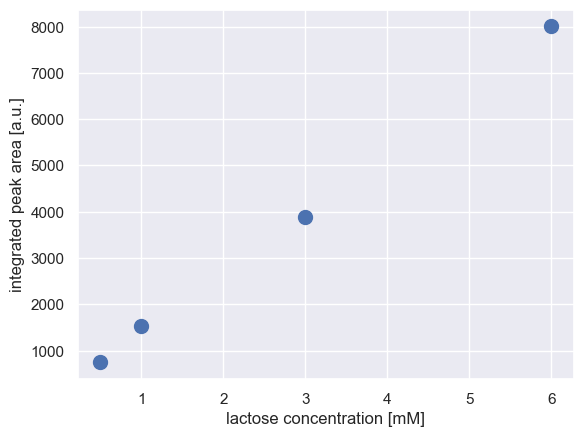

In [7]:
import matplotlib.pyplot as plt

# Plot the calibration curve. 
plt.plot(cal_curve['conc_mM'], cal_curve['amplitude'], 'o', markersize=10)
plt.xlabel('lactose concentration [mM]')
plt.ylabel('integrated peak area [a.u.]')

We can perform a simple regression on these data to get a calibration curve. 

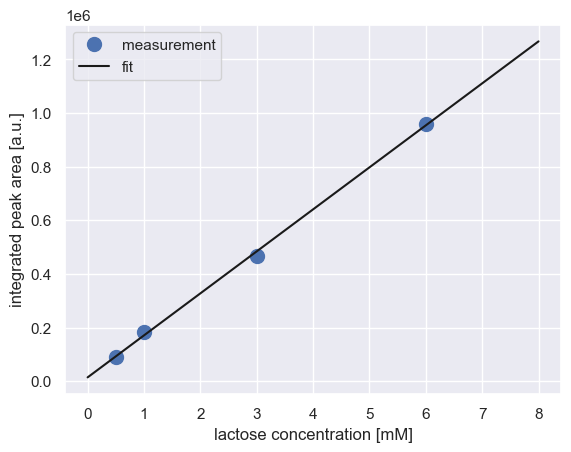

In [8]:
import numpy as np
from scipy.stats import linregress

#  Compute the best fit calibration curve
fit_params = linregress(cal_curve['conc_mM'], cal_curve['area'])
slope = fit_params[0]
intercept = fit_params[1]

# Plot the fit over the data
conc_range = np.linspace(0, 8, 100)
cal = intercept + slope * conc_range
plt.plot(cal_curve['conc_mM'], cal_curve['area'], 'o', markersize=10, label='measurement')
plt.plot(conc_range, cal, '-', color='k', label='fit')
plt.xlabel('lactose concentration [mM]')
plt.ylabel('integrated peak area [a.u.]')
plt.legend()

## Testing the Calibration
We also have a set of lactose solutions with known concentrations that we did not use when fitting the 
calibration curve. We can use the `.map_peaks` method when quantifying these test 
data to see if we get the same concentrations out that we know the peaks represent.  

In [11]:
# Load the test data 
files = glob.glob('data/test/lactose*.csv')

# Instantiate a dataframe to store the results
test_data = pd.DataFrame([])

# Iterate through each file and quantify the peaks
for f in files:
    df = load_chromatogram(f, cols=['time', 'signal'])
    chrom = Chromatogram(df)
    peaks =  chrom.fit_peaks(verbose=False)

    # Now, use the map_peaks method to quantify the signal based off our 
    # calibration curve
    mapping = {'lactose': {'retention_time': 13.56,
                           'slope': slope,
                           'intercept': intercept,
                           'unit': 'mM'}}
    measured_conc = chrom.map_peaks(params=mapping)

    # Parse the known concentration from the file name
    known_conc = float(f.split('_')[-1][:-4])

    # Add it to the dataframe and concatenate
    measured_conc['true_conc_mM']  = known_conc
    test_data  = pd.concat([test_data, measured_conc])
test_data

,retention_time,scale,skew,amplitude,area,peak_id,compound,concentration,unit,true_conc_mM
0,13.56,0.281449,1.664460,10715.647302,1.285878e+06,1,lactose,8.118521,mM,8.0
0,13.56,0.280590,1.649293,5316.675668,6.380011e+05,1,lactose,3.981028,mM,4.0
0,13.56,0.279968,1.639223,2600.400896,3.120481e+05,1,lactose,1.899415,mM,2.0
0,13.56,0.279544,1.636299,2154.143764,2.584973e+05,1,lactose,1.557426,mM,1.5


It looks like it's in good agreement! We can confirm this by plotting the measured 
value versus the true value. If in agreement, everything should fall on the identity line.     

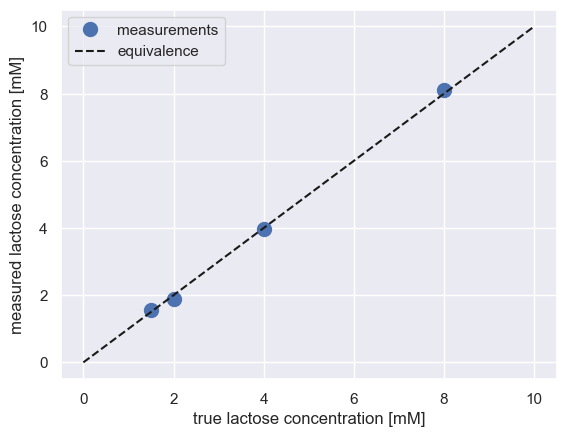

In [14]:
# Plot the measured versus known value of the test set
plt.plot(test_data['true_conc_mM'], test_data['concentration'], 'o', 
         markersize=10, label='measurements')
plt.plot([0, 10], [0, 10], 'k--', label='equivalence')
plt.xlabel('true lactose concentration [mM]')
plt.ylabel('measured lactose concentration [mM]')
plt.legend()
